## Tutorial 3: Quantum Variational Kernel
#### Julien Rauch, December 2025

- Documentation from KIT: https://publikationen.bibliothek.kit.edu/1000148603
- Documentation from pennylane: https://pennylane.ai/qml/demos/tutorial_kernels_module

### 1 - Introduction
This time, we will add additional parametric parts to our quantum circuit. The goal is then to find/optimize the circuit parameters in order to improve classification. By tuning the parameters, we modify the quantum states associated with our data, optimize the similarity matrix, and ultimately improve classification.

- $\theta$ is the parameter set of the circuit we want to train.
- In this case, circuit $U$ takes the data $x$ and the parameters $\theta$ and generates the state: $\ket{\phi_{\theta}(x)} = U(x, \theta)\ket{0}^n$
- We defines a variational kernel function as: $k_{\theta}(x_i, x_j) = |\braket{\phi_{\theta}(x_i)|\phi_{\theta}(x_j)}_{H^n}|^2$. We can consider it as a measure of similarity between $x_i$ and $x_j$ in the Hilbert space.

### 2 - Quantum Circuit

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

We will create a circuit consisting of the embedding section from the previous tutorial, and we will add a parametric section consisting of $Ry$ gates and $controled~Rz$ gates connected circularly (inspired of EfficientSU2 feature map). 

Here is the circuit in question for a single layer:

![image](./img/circuit_var.png)

In [66]:
def embbeding_parametric_circuit(nb_qubit, nb_feature, name_param="parameters", name_input="input", nb_layer=1):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        name_param : name will be the identifier of the ParameterVector corresponding to the parameters
        name_input : name will be the identifier of the ParameterVector corresponding to the input
        nb_layer : number of layers in the circuit
        This function returns the embedding and variational circuit.
    """
    #TODO create the embedding circuit

    # Create parameter vectors for inputs and parameters
    input_params = ParameterVector(name_input, nb_feature)
    param_params = ParameterVector(name_param, nb_layer * nb_qubit * 2)
    circuit = QuantumCircuit(nb_qubit)

    if nb_qubit>1:
        for layer in range(nb_layer):
            circuit.h(range(nb_qubit))
            for i in range(nb_qubit):
                circuit.rz(input_params[i % nb_feature], i)
                circuit.ry(param_params[i], i)
            for i in range(nb_qubit):
                circuit.cx(i, (i + 1) % nb_qubit)
                circuit.rz(param_params[nb_qubit + i], (i + 1) % nb_qubit)
                circuit.cx(i, (i + 1) % nb_qubit)
                

    else:
        for layer in range(nb_layer):
            circuit.h(range(nb_qubit))
            for i in range(nb_qubit):
                circuit.rz(input_params[i % nb_feature], i)
                circuit.ry(param_params[i], i)

    

    
    return circuit

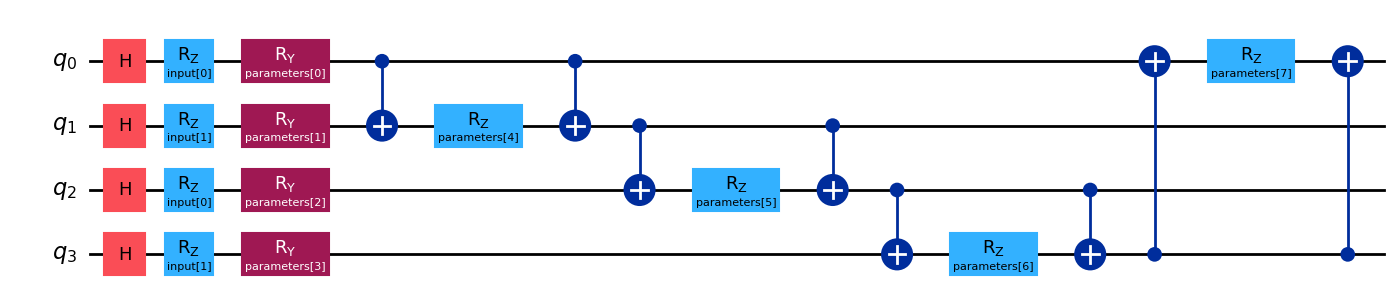

In [4]:
# Print the circuit
embbeding_parametric_circuit(4,2).draw('mpl') # Basic printing, you can improve

### 3 - Fidelity Circuit (Computation of quantum states similarities)

Take the quantum fidelity circuit generation functions designed in the previous tutorial (```fidelity_adjoint_circuit``` or ```fidelity_SwapTest_circuit```) and adapt it to the new embedding circuit.

Please note that although the parameters corresponding to the input data for the two circuits are different, the parameters dedicated to the variational algorithm are the same. This can lead to ```ParameterVector``` name conflicts to solve.

In [5]:
def fidelity_circuit(nb_qubit, nb_feature, nb_layer=1):
    """
        nb_qubit : nomber of qubits in the circuit
        nb_feature : nb_feature of data
        nb_layer : number of layers in the circuit
        This function do the circuit for fidelity
    """
    # TODO
    circ = QuantumCircuit(nb_qubit)
    qc1 = embbeding_parametric_circuit(nb_qubit, nb_feature, name_param="param1", name_input="input1", nb_layer=nb_layer)
    qc2 = embbeding_parametric_circuit(nb_qubit, nb_feature, name_param="param2", name_input="input2", nb_layer=nb_layer).inverse()
    circ.compose(qc1, inplace=True)
    circ.compose(qc2, inplace=True)
    circ.measure_all()
    return circ    

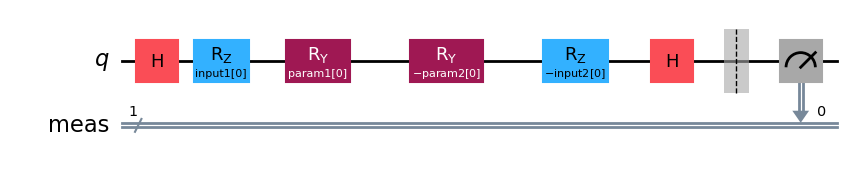

In [6]:
# Print the circuit
fidelity_circuit(1, 1).draw('mpl')

### 4 - Fidelity computation

In this section, we aim to calculate the $n*n$ similarity between the $n$ data points in the dataset.

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

nb_shots = 2048 #1024 by default
sim = AerSimulator(shots=nb_shots)

pm = generate_preset_pass_manager(backend=sim, optimization_level=1) 

Draw inspiration from ```similarity_adjoint``` or ```similarity_swap``` from previous tutorial to implement the ```similarity_computation``` function, which must also assign the variational parameters to the circuit.

In [42]:
def similarity_computation(nb_qubit, nb_feature, dataset, parameters, backend, pass_manager, nb_layer=1):
    """
        nb_qubit : nomber of qubits in the circuit
        nb_feature : nb_feature of data
        dataset : data to embedded
        parameters : parameters of the variational circuit
        backend : backend to run the circuit
        pass_manager : pass manager to transpose the circuit by adapting it to the backend
        nb_layer : number of layers in the circuit
        This function run the circuit of fidelity and return the similarity matrix
    """
    n = len(dataset)
    m = len(parameters)
    res = np.eye(n) # similarity matrix to be completed


    # TODO
    sampler = Sampler(mode=backend)
    qc = fidelity_circuit(nb_qubit, nb_feature, nb_layer=nb_layer)
    transpiled_qc = pass_manager.run(qc)

    
    circuits = []
    for i in range(n):
        for j in range(i+1, n):
            param_dict = {f"input1[{k}]": dataset[i][k] for k in range(nb_feature)}
            param_dict.update({f"input2[{k}]": dataset[j][k] for k in range(nb_feature)})
            param_dict.update({f"param1[{l}]": parameters[l] for l in range(m)})
            param_dict.update({f"param2[{l}]": parameters[l] for l in range(m)})
            qc = transpiled_qc.assign_parameters(param_dict)
            circuits.append(qc)


    sampler = Sampler(backend)
    job = sampler.run(circuits, shots=nb_shots)
    results = job.result()

    k = 0
    for i in range(n):
        for j in range(i+1, n):
            result = results[k]
            count_data = result.data.meas.get_counts()
            fidelity = count_data.get("0" * nb_qubit, 0) / result.metadata["shots"]

            res[i][j] = fidelity
            res[j][i] = fidelity
            k += 1

    return res


    #TODO

In [94]:
# Compute and print the similarity matrix
similarity_computation(1, 1, [[0.2], [0.8], [1.4]], np.random.random(1), sim, pm)

array([[1.        , 0.93164062, 0.72460938],
       [0.93164062, 1.        , 0.92675781],
       [0.72460938, 0.92675781, 1.        ]])

### 5 - Data Clustering with a Quantum Kernel Method

In this section, we aim to perform a data clustering using our previous parametric circuit with random parameters.

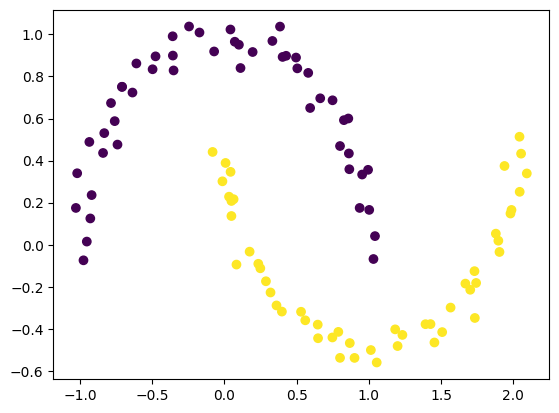

In [125]:
from sklearn.datasets import make_moons
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
X_moons, y_moons = make_moons(100, noise=0.05)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)

Do the clustering like in the previous tutorial (for the parameters uses ```np.random.random``` for now).

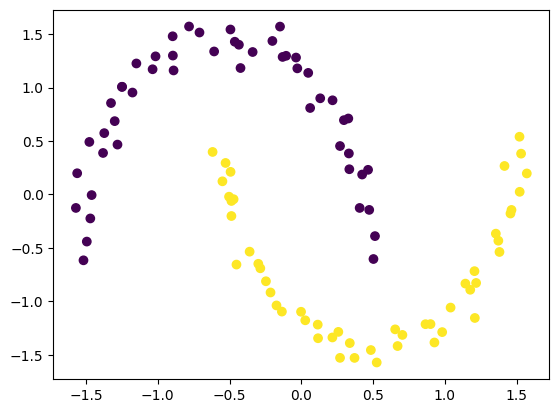

In [126]:
# TODO do the preprocessing
from sklearn.preprocessing import MinMaxScaler
X_moons = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2)).fit_transform(X_moons)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)

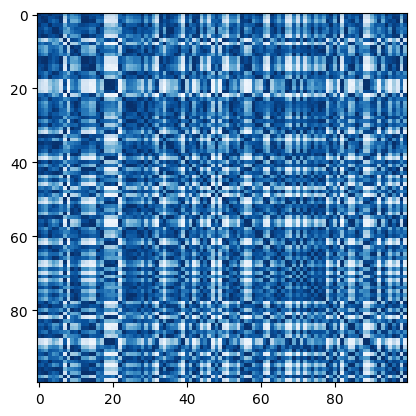

In [127]:
# TODO: call your similarity matrix computation and run a spectral clustering
params = np.random.random(4) * np.pi - (np.pi / 2)

similarity = similarity_computation(2, 2, X_moons, params, sim, pm)

plt.imshow(
   similarity, interpolation="nearest", origin="upper", cmap="Blues"
)

Clustering score: 0.1320091805411247


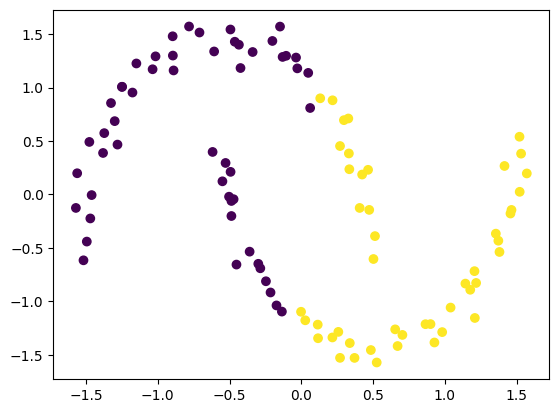

In [128]:
# TODO Compute and print the NMI result
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

# Run a spectral clustering from similarity matrix
adhoc_spectral = SpectralClustering(2, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(similarity)

# Compute the NMI metric that gives the quality of the results (comparaison to official labeling)
cluster_score = normalized_mutual_info_score(cluster_labels, y_moons)

# Print the NMI result
print(f"Clustering score: {cluster_score}")

# TODO Display the dataset with computed labeling

# Display the dataset with computed labeling
plt.scatter(X_moons[:,0], X_moons[:,1], c=cluster_labels)

## 6 - Variational algorithm for classification

This section is devoted to the implementation and experimentation of the complete ML algorithm in order to obtain optimal classification.

In [129]:
from IPython.display import clear_output
from scipy.optimize import minimize
score = []

#This function will display the result of our classification and the evolution of the score (NMI) at each loop (epoch).
def plot_training_progress(cluster_labels_save):

    if len(score) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # NMI
    ax1.set_title("Classification Score")
    ax1.plot(score)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("NMI")

    # Labeling
    ax2.set_title("Labeling")
    ax2.scatter(X_moons[:,0], X_moons[:,1], c=cluster_labels_save)

    plt.show()

### 6.1 - Design of the objective function

To optimize the classification we first design an "objective function" that takes as parameters those that must be supplied to our circuit and returns a score that we want to minimize. 

This objective function will be used at the next section.

In [134]:
def target_alignment(kernel_matrix, labels):
    """
    Computes the Kernel Target Alignment (KTA) between the kernel matrix 
    and the ideal target matrix formed by the labels.
    """
    # Create the ideal target matrix T where T_ij = 1 if same class, -1 if different
    # Assuming labels are 0 and 1, we convert them to -1 and 1
    y = np.array(labels)
    y = 2 * y - 1 
    T = np.outer(y, y)
    
    # Calculate alignment (Cosine similarity between matrices)
    inner_product = np.sum(kernel_matrix * T)
    norm_k = np.sqrt(np.sum(kernel_matrix * kernel_matrix))
    norm_t = np.sqrt(np.sum(T * T))
    
    return inner_product / (norm_k * norm_t)

def f_objective(parameter):
    # 1. Compute the Similarity Matrix (Kernel) using the current parameters
    # Note: X_moons, y_moons, sim, and pm must be defined globally
    similarity = similarity_computation(2, 2, X_moons, parameter, sim, pm, nb_layer=1)
    
    # 2. Run Spectral Clustering and Compute NMI (For Visualization Only)
    adhoc_spectral = SpectralClustering(2, affinity="precomputed")
    cluster_labels = adhoc_spectral.fit_predict(similarity)
    nmi = normalized_mutual_info_score(y_moons, cluster_labels)

    # 3. Store score and update plot
    score.append(nmi)
    # Using 'cluster_labels' here as your template requested, assuming 
    # plot_training_progress handles the visualization of clusters or the score curve
    plot_training_progress(cluster_labels) 

    # 4. Compute Kernel Target Alignment (KTA)
    # This provides a smooth gradient for the optimizer
    kta = target_alignment(similarity, y_moons)

    # Return negative KTA (because we want to MAXIMIZE alignment, but minimize() minimizes)
    return -kta

### 6.2 - Run the learning loop

We will use the ```minimize``` function from the ```scipy.optimize``` module on the previous objective function.

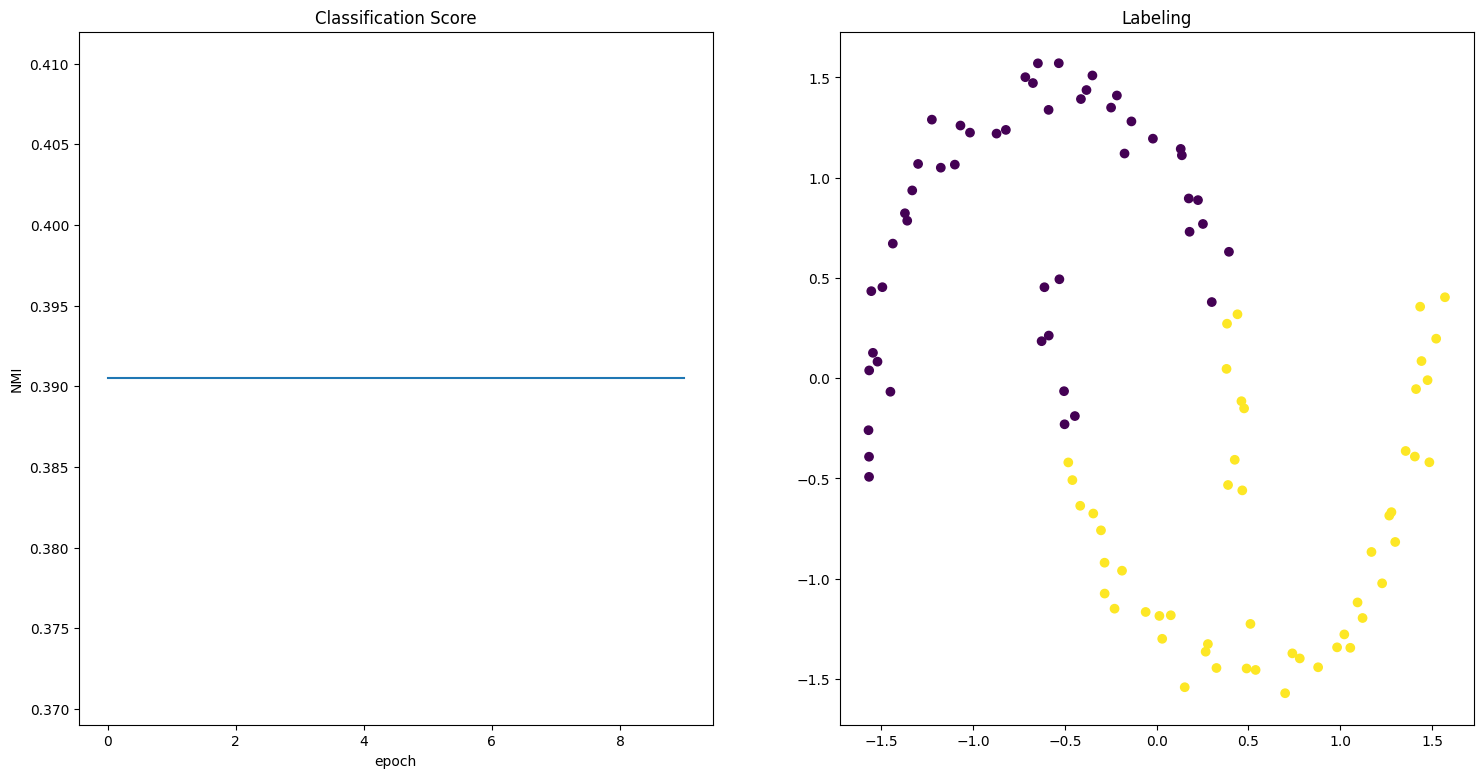

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [68]:
# We initialize the score list to store the evolution of the NMI.
score = []

#TODO Initialize the parameters
x0 = np.random.random(4) * np.pi - (np.pi / 2)

#TODO Run minimize function (method='COBYLA') and stock the result in a variable
res = minimize(f_objective, x0, method='COBYLA')

Display the final result

In [ ]:
# TODO: call your similarity matrix computation and run a spectral clustering with the optimized parameters
#similarity = ...

# TODO Compute and print the NMI result

# TODO Display the dataset with computed labeling

### 6.3 - Problem identification and resolution

what is preventing it from working ?

Modify the circuit to overcome this problem.

### 6.3 - Problem Identification and Resolution

#### What is preventing it from working?

The issue is **parameter cancellation** in the fidelity circuit. When computing the kernel $k_{\theta}(x_i, x_j) = |\langle\phi_{\theta}(x_i)|\phi_{\theta}(x_j)\rangle|^2$, we construct the circuit:

$$U(x_i, \theta) \cdot U^{\dagger}(x_j, \theta)$$

In the original circuit, the parametric gates ($R_y(\theta)$, $\text{CRz}(\theta)$) appear before data encoding. When composed with their inverse, they cancel:

$$R_y(\theta) \cdot R_y^{\dagger}(\theta) = I$$

This makes the kernel **independent of $\theta$**, resulting in zero gradients ($\nabla_{\theta} f = 0$) and constant NMI during optimization.

#### Solution: Reorder Circuit Operations

Place **data encoding AFTER parametric gates**:

**Original (Wrong):** `H → Rz(data) → Ry(params) → CX → CRz(params)`  
**Corrected:** `H → Ry(params) → CX → CRz(params) → Rz(data)`

The parametric gates still cancel, but now the data encoding $R_z(x_i - x_j)$ occurs in a $\theta$-dependent basis, making the kernel trainable.

#### Modified Circuit Implementation



In [136]:
def embbeding_parametric_circuit(nb_qubit, nb_feature, name_param="parameters", name_input="input", nb_layer=1):
    # ... (Keep existing setup for ParameterVectors) ...
    input_params = ParameterVector(name_input, nb_feature)
    param_params = ParameterVector(name_param, nb_layer * nb_qubit * 2)
    circuit = QuantumCircuit(nb_qubit)

    if nb_qubit > 1:
        for layer in range(nb_layer):
            circuit.h(range(nb_qubit))
            
            # --- SOLUTION: Apply Parameters FIRST ---
            for i in range(nb_qubit):
                # Apply Ry parameters
                circuit.ry(param_params[layer * nb_qubit * 2 + i], i) 
                
            # Apply Entanglement (also parameters)
            for i in range(nb_qubit):
                circuit.cx(i, (i + 1) % nb_qubit)
                circuit.rz(param_params[layer * nb_qubit * 2 + nb_qubit + i], (i + 1) % nb_qubit)
                circuit.cx(i, (i + 1) % nb_qubit)
                
            # --- SOLUTION: Apply Data Encoding LAST ---
            # This acts as the "barrier" to prevent cancellation
            for i in range(nb_qubit):
                circuit.rz(input_params[i % nb_feature], i)

    else:
        # Apply the same logic for the single qubit case
        for layer in range(nb_layer):
            circuit.h(range(nb_qubit))
            for i in range(nb_qubit):
                circuit.ry(param_params[i], i) # Param first
                circuit.rz(input_params[i % nb_feature], i) # Data last

    return circuit

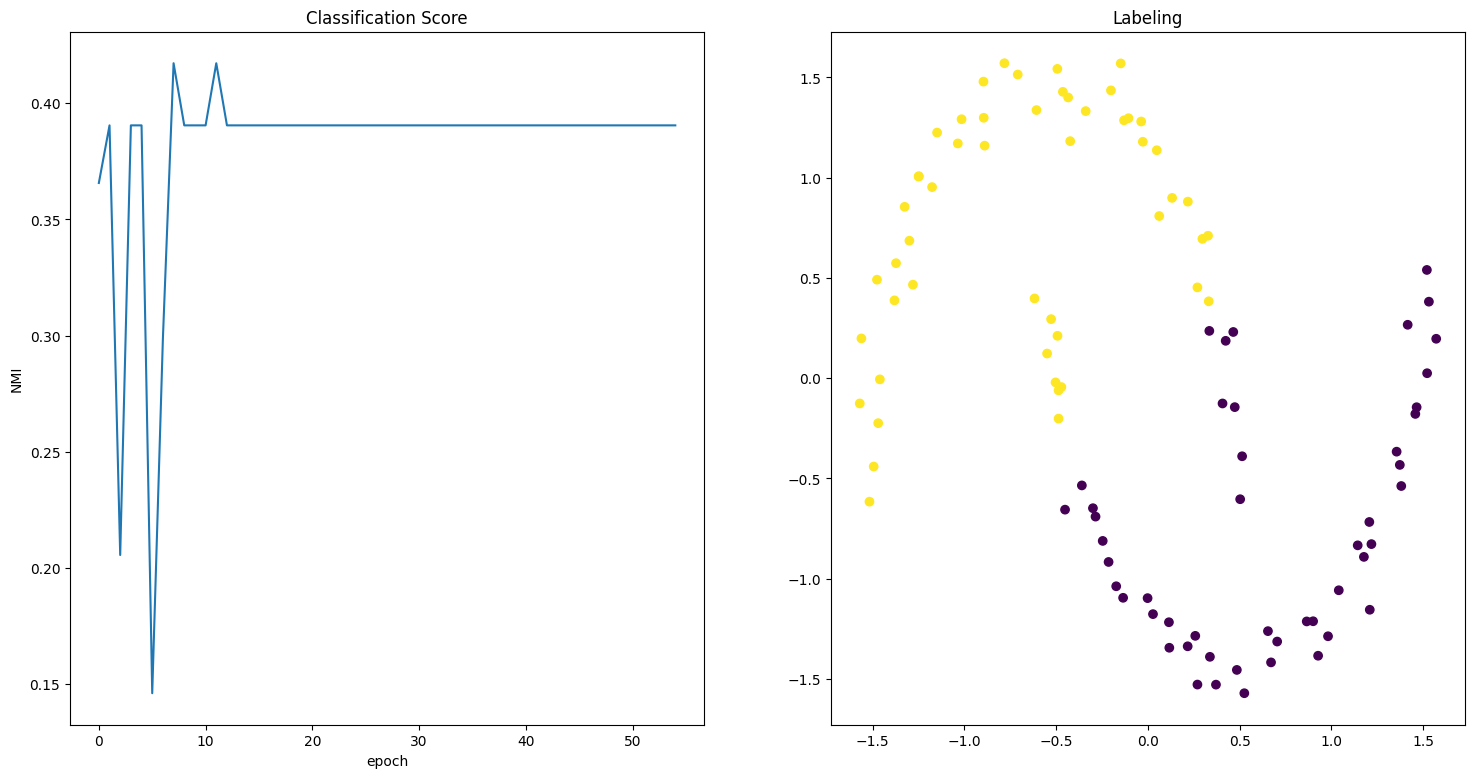

In [138]:
# We initialize the score list to store the evolution of the NMI.
score = []
#TODO Initialize the parameters
# Parameter initialization
nb_qubits = 2
nb_layers = 1
x0 = np.random.uniform(-np.pi/2, np.pi/2, size=nb_layers * nb_qubits * 2)

#TODO Run minimize function (method='COBYLA') and stock the result in a variable
res = minimize(f_objective, x0, method='COBYLA')